Paper: Parsimonious Learning-Augmented Caching

In [1]:
import numpy as np
import pandas as pd
# %matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator)
from IPython.display import ProgressBar
import ipywidgets as widgets
import os

In [2]:
plt.rcParams.update({'font.size': 12})

## Previous Data

Goal: Reproduce the results of that paper. Mainly that table here:

| Algorithms | Mean Predictions | σ=0 | σ=2 | σ=4 | σ=6 |
|------------|------------------|-----|-----|-----|-----|
| RandomMarker | 3.14 | 3.14 | 3.14 | 3.14 | 3.14 |
| LRU | 2.86 | 2.86 | 2.86 | 2.86 | 2.86 |
| BlindOracle | 1.92 | 1.00 | 1.02 | 3.92 | 4.15 |
| LVMarker | 2.49 | 1.77 | 1.81 | 2.94 | 3.11 |
| RohatgiMarker | 2.54 | 1.77 | 1.83 | 3.15 | 3.29 |
| RobustOracle | 4.29 | 1.80 | 1.83 | 4.48 | 4.51 |
| AdaptiveQuery-2 | 2.91 | 2.46 | 2.46 | 2.52 | 2.65 |
| AdaptiveQuery-4 | 2.71 | 2.07 | 2.07 | 2.20 | 2.49 |
| AdaptiveQuery-8 | 2.59 | 1.86 | 1.86 | 2.07 | 2.54 |

## Global variables

In [3]:
year = 2018
folder = "start_stations"

## Algorithms

### Data fetching

In [4]:
def get_data(folder, year, month, n, k):
    pages = pd.read_csv(f"{folder}/{year}{month:02d}-citibike-stations.csv", header=None)[0].head(n)
    warmed_up_cache = set(pages.unique()[:k])
    rounds_per_page = compute_rounds_per_page(list(pages))
    return pages, warmed_up_cache, rounds_per_page

def compute_rounds_per_page(pages: list):
    rounds_per_page = {}
    for round, page in enumerate(pages):
        if page in rounds_per_page:
            rounds_per_page[page].append(round) # sorted list of rounds
        else:
            rounds_per_page[page] = [round]
    return rounds_per_page

### Helper functions

In [5]:
def find_next_round(rounds_per_page: dict, last_idxs: dict, page: int, cur_round: int, n: int):
    # Binary search for the next round larger then `cur_round` for that page
    idx = last_idxs.get(page, 0)
    rounds = rounds_per_page[page]
    while idx < len(rounds) and rounds[idx] <= cur_round:
        idx += 1
    last_idxs[page] = idx
    return rounds[idx] if idx < len(rounds) else n + 1

def find_last_round(rounds_per_page: dict, last_idxs: dict, page: int, cur_round: int):
    # Binary search for the last round smaller then cur_round for that page
    idx = last_idxs.get(page, 0)
    rounds = rounds_per_page[page]
    while idx < len(rounds) - 1 and rounds[idx + 1] < cur_round:
        idx += 1
    last_idxs[page] = idx
    return rounds[idx]

### Eviction strategies

In [6]:
class EvictionStrategy:
    """ Abstract eviction strategy

    Attributes
    ---
    rng: np.random.Generator
        Random number generator
    sigma: int
        Standard deviation for the synthetic predictions
    mode: bool
        If True, use synthetic predictions, otherwise use the mean predictions
    """

    def __init__(self, rng: np.random.Generator, sigma: int, mode: bool = True):
        self.rng = rng
        self.sigma = sigma
        self.mode = mode
        self.count_queries = 0
    
    def reset(self, n: int, k: int, logk: int):
        self.n = n
        self.k = k
        self.logk = logk
        self.count_queries = 0

    def predict_next_round(self, rounds_per_page: dict, last_idxs: dict, page: int, round: int):
        self.count_queries += 1
        
        if self.mode:
            # Synthetic Predictions
            return find_next_round(rounds_per_page, last_idxs, page, round, self.n) + self.rng.lognormal(0, self.sigma)
        
        # Mean Predictions
        last_t = find_last_round(rounds_per_page, last_idxs, page, round)
        rounds = rounds_per_page[page]
        mean_diff = (rounds[-1] - rounds[0]) // len(rounds)
        return last_t + mean_diff
    
    def evict(self, cache: set, rounds_per_page: dict, last_idxs: dict, round: int, chain_length: int = 0):
        """ Abstract eviction method a subclass needs to implement
        """
        raise NotImplementedError

class FarthestInTheFuture(EvictionStrategy):
    """ Evicts the page with the farthest next request time
    """
    def evict(self, cache: set, rounds_per_page: dict, last_idxs: dict, round: int, chain_length: int = 0):
        return max([(find_next_round(rounds_per_page, last_idxs, page, round, self.n), page) for page in cache])[1]

class BlindOracle(EvictionStrategy):
    """ Evicts the page with the latest predicted next request time
    """
    def evict(self, cache: set, rounds_per_page: dict, last_idxs: dict, round: int, chain_length: int = 0):
        return max([(self.predict_next_round(rounds_per_page, last_idxs, page, round), page) for page in cache])[1]

class RandomMarker(EvictionStrategy):
    """ Evicts a randomly chosen unmarked page
    """
    def evict(self, unmarked_pages: set, rounds_per_page: dict, last_idxs: dict, round: int, chain_length: int):
        return self.rng.choice(list(unmarked_pages))

class LRU(EvictionStrategy):
    """ Evicts the least recently used (unmarked) page
    """
    def evict(self, unmarked_pages: set, rounds_per_page: dict, last_idxs: dict, round: int, chain_length: int):
        return min([(find_last_round(rounds_per_page, last_idxs, page, round), page) for page in unmarked_pages])[1]
    
class LVMarker(EvictionStrategy):
    """ Evicts the page with the furthest predicted arrival until the length of the eviction chain is O(log k)
        and then switches to evicting a randomly chosen unmarked page
    """
    def evict(self, unmarked_pages: set, rounds_per_page: dict, last_idxs: dict, round: int, chain_length: int):
        if chain_length > self.logk:
            return self.rng.choice(list(unmarked_pages))
        return max([(self.predict_next_round(rounds_per_page, last_idxs, page, round), page) for page in unmarked_pages])[1]

class RohatgiMarker(EvictionStrategy):
    """ Evicts the page with the furthest predicted arrival until the length of the eviction chain is 1
    """
    def evict(self, unmarked_pages: set, rounds_per_page: dict, last_idxs: dict, round: int, chain_length: int):
        if chain_length > 1:
            return self.rng.choice(list(unmarked_pages))
        return max([(self.predict_next_round(rounds_per_page, last_idxs, page, round), page) for page in unmarked_pages])[1]
    
class AdaptiveQuery(EvictionStrategy):
    """ Evicts the page with the latest predicted next request time among `b` randomly chosen unmarked pages
    """
    def __init__(self, rng, sigma, mode, b):
        super().__init__(rng, sigma, mode)
        self.b = b

    def evict(self, unmarked_pages: set, rounds_per_page: dict, last_idxs: dict, round: int, chain_length: int):
        # Worst-case guarantee
        if chain_length > self.logk:
            return self.rng.choice(list(unmarked_pages))

        samples = self.rng.choice(list(unmarked_pages), self.b, replace=False) if self.b <= len(unmarked_pages) else unmarked_pages
        return max([(self.predict_next_round(rounds_per_page, last_idxs, page, round), page) for page in samples])[1]

### Paging Algorithms

In [7]:
def generic_algorithm(cache: set, pages: list, rounds_per_page: dict, n: int, k: int, logk: int, eviction_strategy: EvictionStrategy):
    count = 0
    last_idxs = {}
    eviction_strategy.reset(n, k, logk)
    
    for round, page in enumerate(pages):
        if page in cache:
            pass
        else:
            evicted_page = eviction_strategy.evict(cache, rounds_per_page, last_idxs, round)
            cache.remove(evicted_page)
            cache.add(page)
            count += 1
    return count

def generic_marking_algorithm(cache: set, pages: list, rounds_per_page: dict, n: int, k: int, logk: int, eviction_strategy: EvictionStrategy):
    count = 0
    unmarked: set = cache.copy()
    last_idxs = {}
    chain_lengths = {}
    eviction_strategy.reset(n, k, logk)
    
    for round, page in enumerate(pages):
        if page in cache:
            if page in unmarked:
                unmarked.remove(page)
        else:
            # unmark all pages if all pages are marked
            if len(unmarked) == 0:
                # start of new phase
                unmarked = cache.copy()
                chain_lengths = {}
            
            # Either it's a clean page that starts a new eviction chain or it's a stale page that got evicted before
            chain_length = chain_lengths.get(page, 0)
            
            # evict an unmarked page
            evicted_page = eviction_strategy.evict(unmarked, rounds_per_page, last_idxs, round, chain_length)
            cache.remove(evicted_page)
            
            if evicted_page in unmarked:
                unmarked.remove(evicted_page)
            chain_lengths[evicted_page] = chain_length + 1
            count += 1
            chain_length += 1
            
            # add current page to cache and mark it
            cache.add(page)
    return count

## Boxplots

In [8]:
# Call paging algorithms and output results
def compute_for_month(month, sigmas, repetitions=10, n=25000, k=512, logk=9, mode=True):
    pages, warmed_up_cache, rounds_per_page = get_data(folder, year, month, n, k)

    # Run deterministic algorithms first
    fif = generic_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, FarthestInTheFuture(np.random.default_rng(), 0, mode))
    lru = generic_marking_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, LRU(np.random.default_rng(), 0, mode))

    # Run probabilistic algorithms 100 times
    data = []
    for sigma in sigmas:
        for _i in range(repetitions):
            data.append({
                'month':            month,
                'sigma':            sigma,
                'fif':              fif,
                'blind_oracle':     generic_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, BlindOracle(np.random.default_rng(), sigma, mode)),
                'random_marker':    generic_marking_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, RandomMarker(np.random.default_rng(), sigma, mode)),
                'lru':              lru,
                'lv_marker':        generic_marking_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, LVMarker(np.random.default_rng(), sigma, mode)),
                'rohatgi_marker':   generic_marking_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, RohatgiMarker(np.random.default_rng(), sigma, mode)),
                'adaptive_query_2': generic_marking_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, AdaptiveQuery(np.random.default_rng(), sigma, mode, 2)),
                'adaptive_query_4': generic_marking_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, AdaptiveQuery(np.random.default_rng(), sigma, mode, 4)),
                'adaptive_query_8': generic_marking_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk,AdaptiveQuery(np.random.default_rng(), sigma, mode, 8)),
            })

    return pd.DataFrame(data)

def compute_for_all_months(sigmas, repetitions=10, n=25000, k=512, logk=9, mode=True):
    return pd.concat([compute_for_month(i+1, sigmas, repetitions, n, k, logk) for i in ProgressBar(12)])

def queries_for_month(month, sigmas, repetitions=10, n=25000, k=500, logk=9, mode=True):
    pages, warmed_up_cache, rounds_per_page = get_data(folder, year, month, n, k)

    data = []
    for sigma in sigmas:
        for _i in range(repetitions):
            blind_oracle = BlindOracle(np.random.default_rng(), sigma, mode)
            generic_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, blind_oracle)

            lv_marker = LVMarker(np.random.default_rng(), sigma, mode)
            generic_marking_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, lv_marker)

            rohatgi_marker = RohatgiMarker(np.random.default_rng(), sigma, mode)
            generic_marking_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, rohatgi_marker)

            adaptive_query_2 = AdaptiveQuery(np.random.default_rng(), sigma, mode, 2)
            generic_marking_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, adaptive_query_2)

            adaptive_query_4 = AdaptiveQuery(np.random.default_rng(), sigma, mode, 4)
            generic_marking_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, adaptive_query_4)

            adaptive_query_8 = AdaptiveQuery(np.random.default_rng(), sigma, mode, 8)
            generic_marking_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, adaptive_query_8)

            data.append({
                'month':            month,
                'sigma':            sigma,
                'fif':              0,
                'blind_oracle':     blind_oracle.count_queries,
                'random_marker':    0,
                'lru':              0,
                'lv_marker':        lv_marker.count_queries,
                'rohatgi_marker':   rohatgi_marker.count_queries,
                'adaptive_query_2': adaptive_query_2.count_queries,
                'adaptive_query_4': adaptive_query_4.count_queries,
                'adaptive_query_8': adaptive_query_8.count_queries,
            })

    return pd.DataFrame(data)

In [9]:
# compute_for_month(9, [0, 2, 4, 8], repetitions=1, n=25000, k=512, logk=6, mode=True)
# queries_for_month(9, [0, 2, 4, 8], repetitions=1, n=25000, k=500, logk=9, mode=True)

### Synthetic Predictions

In [10]:
filename = "results-synthetic.csv"
if os.path.exists(filename):
    df_crs = pd.read_csv(filename).drop('Unnamed: 0', axis=1)
else:
    df_crs = compute_for_all_months([0, 2, 4, 8], 20, 25000, 500, 6, True) # should take ~43min
    df_crs.to_csv(filename, index=False)

df_crs

,month,sigma,fif,blind_oracle,random_marker,lru,lv_marker,rohatgi_marker,adaptive_query_2,adaptive_query_4,adaptive_query_8
0,1,0,749,749,2285,2080,1331,1331,1849,1547,1394
1,1,0,749,749,2324,2080,1331,1331,1859,1534,1395
2,1,0,749,749,2306,2080,1331,1331,1841,1541,1398
3,1,0,749,749,2292,2080,1331,1331,1812,1545,1398
4,1,0,749,749,2307,2080,1331,1331,1797,1565,1393
...,...,...,...,...,...,...,...,...,...,...,...
955,12,8,1039,4155,3288,3059,3303,3364,2867,2781,3022
956,12,8,1039,4233,3330,3059,3315,3335,2870,2775,2991
957,12,8,1039,4143,3347,3059,3334,3281,2843,2835,3008
958,12,8,1039,4131,3281,3059,3310,3350,2838,2797,2996


In [11]:
df_crs.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
month,960.0,6.500000,3.453852,1.0,3.75,6.5,9.25,12.0
sigma,960.0,3.500000,2.959582,0.0,1.50,3.0,5.00,8.0
fif,960.0,884.916667,107.801585,749.0,809.50,836.5,966.00,1099.0
blind_oracle,960.0,2224.536458,1352.504060,749.0,847.50,2045.0,3488.25,4356.0
random_marker,960.0,2769.578125,357.251873,2259.0,2478.00,2623.0,3055.25,3473.0
lru,960.0,2547.750000,362.672993,2080.0,2263.75,2402.5,2806.75,3222.0
lv_marker,960.0,2144.155208,622.596117,1331.0,1500.00,2082.5,2576.00,3448.0
rohatgi_marker,960.0,2150.630208,628.186276,1331.0,1500.00,2100.0,2566.50,3457.0
adaptive_query_2,960.0,2245.243750,301.761981,1791.0,2004.00,2131.5,2474.50,2955.0
adaptive_query_4,960.0,1990.231250,325.012974,1526.0,1707.00,1979.0,2196.25,2891.0


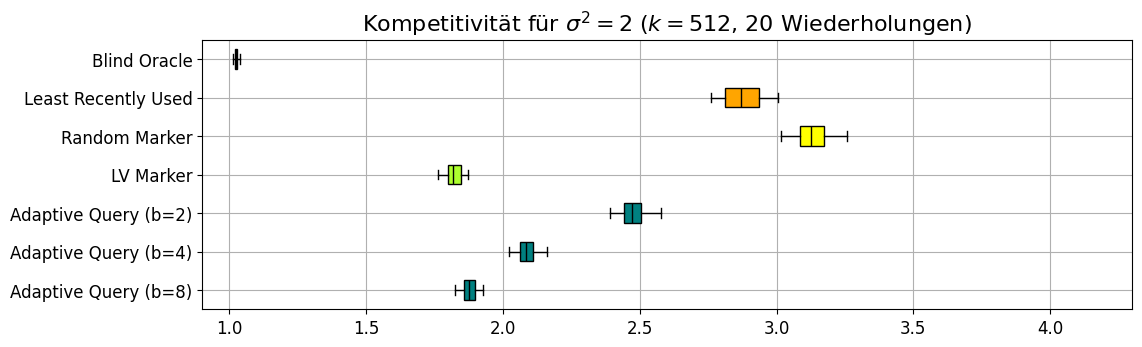

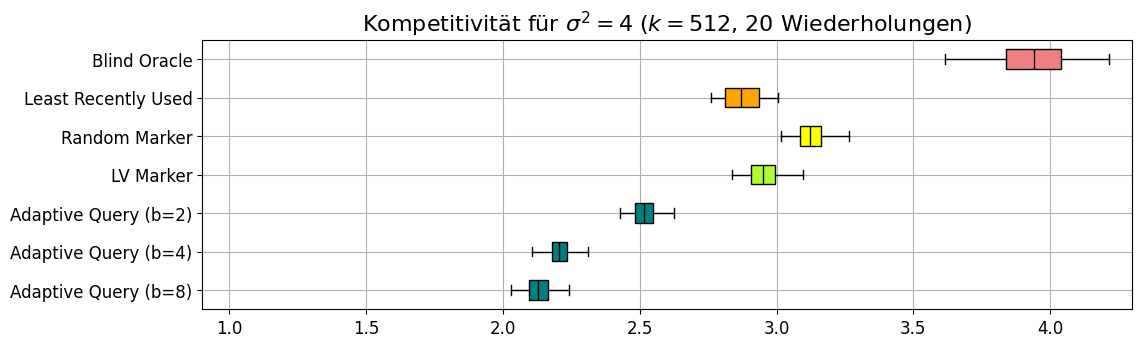

In [12]:
cols = [
    'adaptive_query_8',
    'adaptive_query_4',
    'adaptive_query_2',
    'lv_marker',
    'random_marker',
    'lru',
    'blind_oracle',
]

colors = [
    'teal',
    'teal',
    'teal',
    'greenyellow',
    'yellow',
    'orange',
    'lightcoral'
]

# for i, sigma in enumerate([0, 2, 4, 8]):
for i, sigma in enumerate([2, 4]):
    fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))
    df_crs2 = df_crs[df_crs['sigma'] == sigma].astype('float')
    
    for month in df_crs2['month'].unique():
        # compute competitive ratios: number of cache misses divided by number of cache misses of optimal strategy (FIF)
        df_crs2.loc[df_crs2['month'] == month, cols] /= df_crs2[df_crs2['month'] == month]['fif'].values[0]
    
    df_crs2.drop(columns=['sigma', 'fif', 'month'], inplace=True)
    
    bplot = ax.boxplot(df_crs2[cols].values, vert=False, widths=0.5, patch_artist=True, showfliers=False)
    
    line_width=1.0
    for box, color in zip(bplot['boxes'], colors):
        box.set_facecolor(color)
        box.set_linewidth(line_width)
    for median in bplot['medians']:
        median.set_color('black')
        median.set_linewidth(line_width)
    for whisker in bplot['whiskers']:
        whisker.set_linewidth(line_width)
    for cap in bplot['caps']:
        cap.set_linewidth(line_width)
    
    ax.set_yticks(np.arange(1, len(cols) + 1), [
        'Adaptive Query (b=8)',
        'Adaptive Query (b=4)', 
        'Adaptive Query (b=2)', 
        'LV Marker', 
        'Random Marker', 
        'Least Recently Used', 
        'Blind Oracle', 
    ])
    
    plt.title(fr'Kompetitivität für $\sigma^2={sigma}$ ($k=512$, 20 Wiederholungen)', fontsize=16)
    plt.grid(True)
    plt.xlim(0.9, 4.3)
    plt.show()


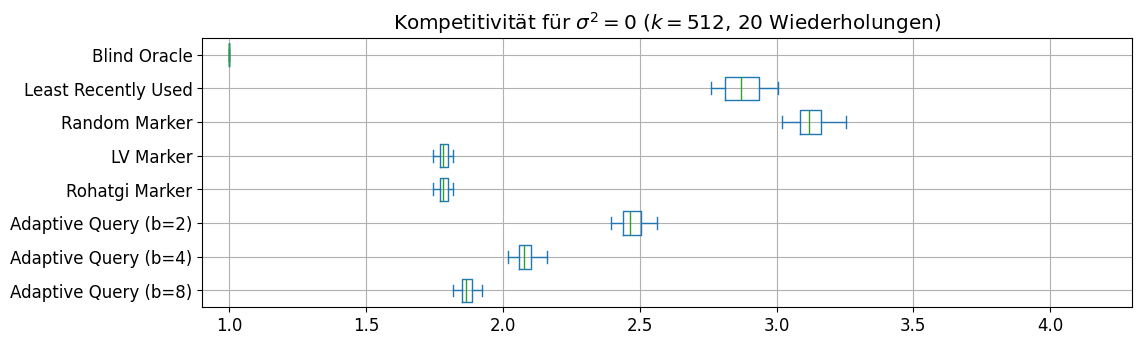

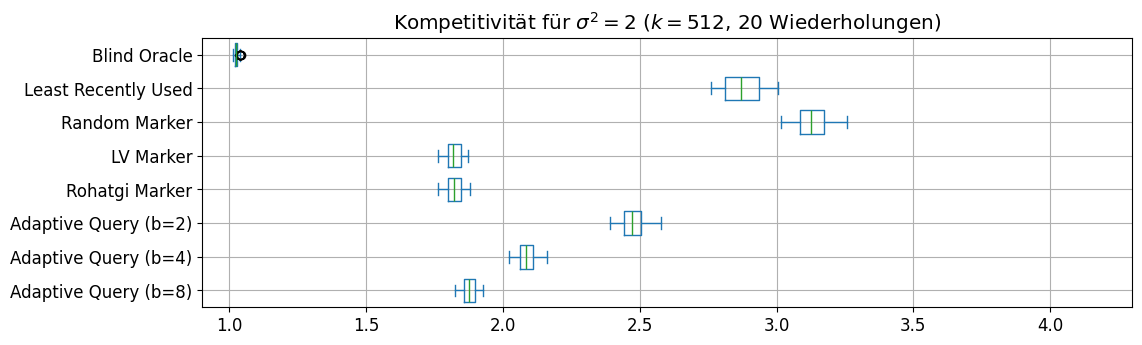

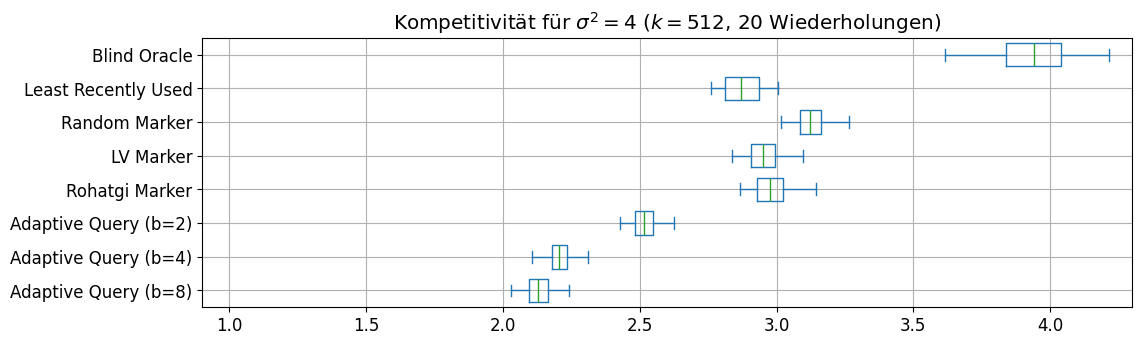

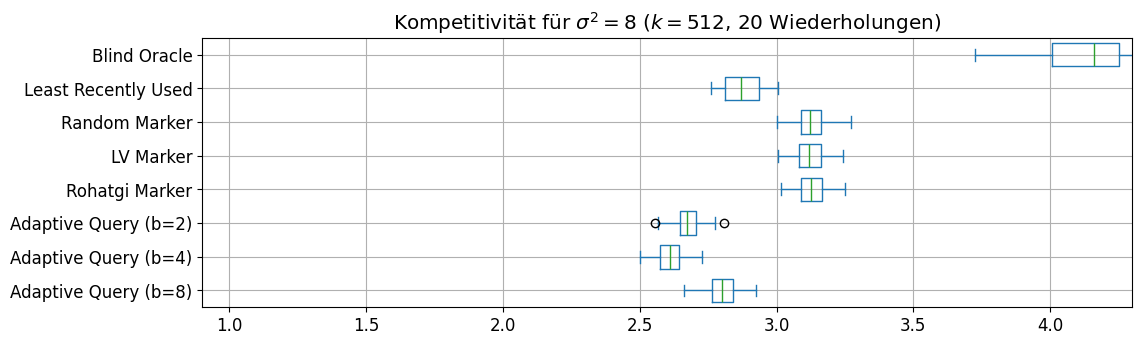

In [13]:
cols = [
    'adaptive_query_8',
    'adaptive_query_4',
    'adaptive_query_2',
    'rohatgi_marker',
    'lv_marker',
    'random_marker',
    'lru',
    'blind_oracle',
]
for i, sigma in enumerate([0, 2, 4, 8]):
    df_crs2 = df_crs[df_crs['sigma'] == sigma].astype('float')
    for month in df_crs2['month'].unique():
        # compute competitive ratios: number of cache misses divided by number of cache misses of optimal strategy (FIF)
        df_crs2.loc[df_crs2['month'] == month, cols] /= df_crs2[df_crs2['month'] == month]['fif'].values[0]
    df_crs2.drop(columns=['sigma', 'fif', 'month'], inplace=True)

    ax = df_crs2.plot.box(vert=False, title=fr'Kompetitivität für $\sigma^2={sigma}$ ($k=512$, 20 Wiederholungen)', grid=True, xlim=(0.9, 4.3), figsize=(12, 3.5), y=cols, widths=0.7)
    ax.set_yticklabels([
        'Adaptive Query (b=8)',
        'Adaptive Query (b=4)', 
        'Adaptive Query (b=2)', 
        'Rohatgi Marker', 
        'LV Marker', 
        'Random Marker', 
        'Least Recently Used', 
        'Blind Oracle', 
    ])

### Number of queries

In [ ]:
filename = "results-queries.csv"
if os.path.exists(filename):
    df_queries = pd.read_csv(filename)
else:
    df_queries = pd.concat([queries_for_month(i+1, [0, 2, 4, 8], 20, 25000, 500, 9, True) for i in ProgressBar(12)])
    df_queries.to_csv(filename, index=False)

df_queries.describe().transpose()

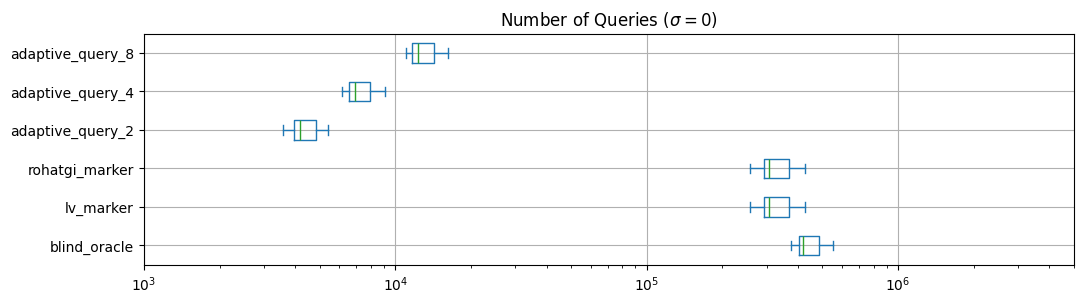

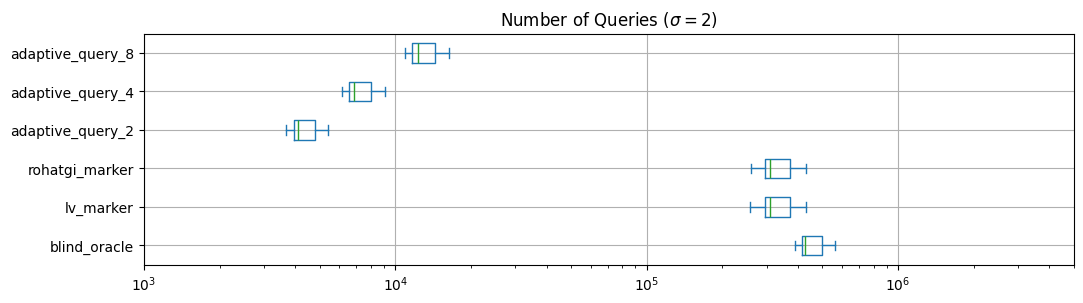

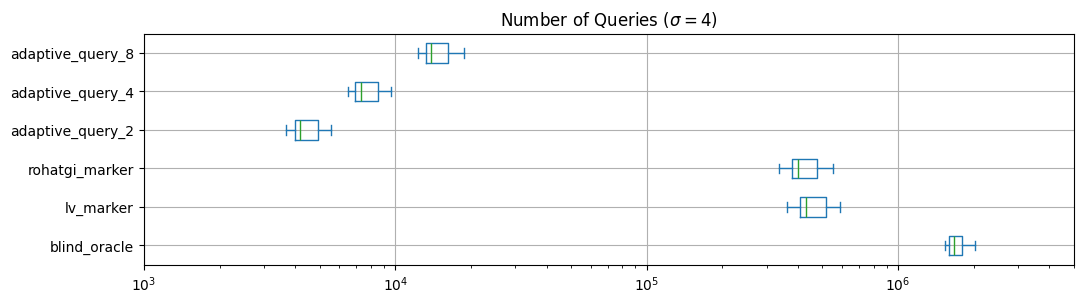

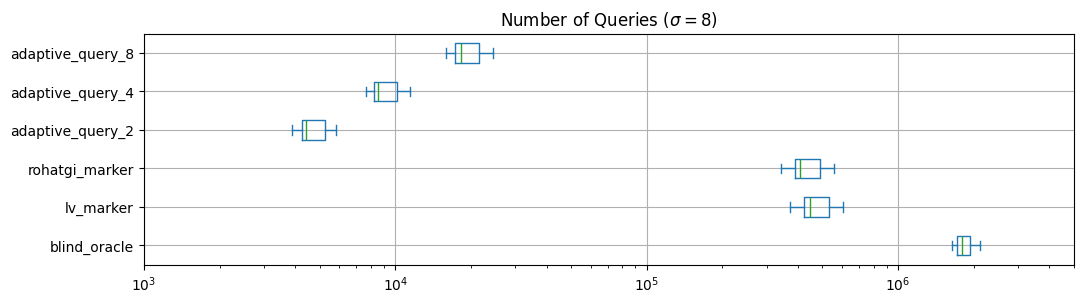

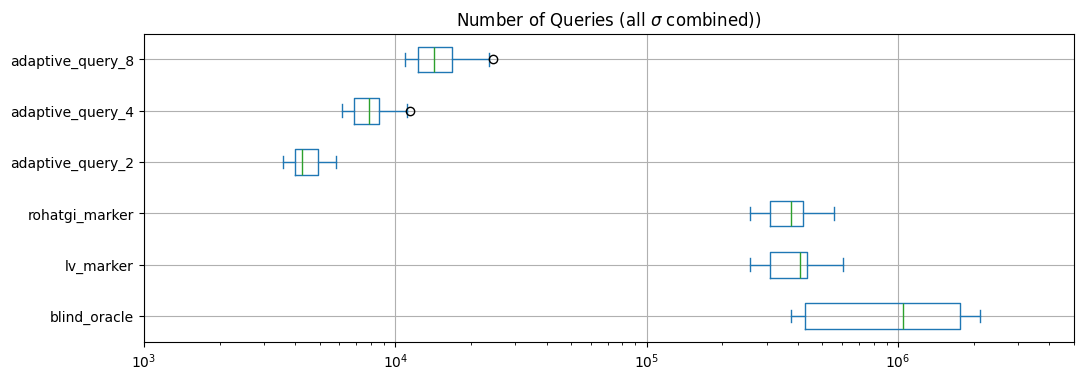

In [ ]:

for sigma in [0, 2, 4, 8]:
    dfq = df_queries[df_queries['sigma'] == sigma].drop(columns=['sigma', 'month', 'lru', 'random_marker', 'fif'])
    dfq.plot.box(vert=False, title=fr'Number of Queries ($\sigma={sigma}$)', grid=True, figsize=(12, 3), logx=True, xlim=(1e3, 5e6))
df_queries.drop(columns=['sigma', 'month', 'lru', 'random_marker', 'fif']).plot.box(vert=False, title=fr'Number of Queries (all $\sigma$ combined))', grid=True, figsize=(12, 4), logx=True, xlim=(1e3, 5e6))
plt.show()

### Mean Predictions

In [16]:
filename = "results-mp.csv"
if os.path.exists(filename):
    df_mp = pd.read_csv(filename)
else:
    df_mp = compute_for_all_months([0], 20, 25000, 500, 9, False)
    df_mp.to_csv(filename, index=False)
df_mp

,Unnamed: 0,month,sigma,fif,blind_oracle,random_marker,lru,lv_marker,rohatgi_marker,adaptive_query_2,adaptive_query_4,adaptive_query_8
0,0,1,0,749,749,2287,2080,1331,1331,1846,1539,1389
1,1,1,0,749,749,2291,2080,1331,1331,1850,1543,1386
2,2,1,0,749,749,2296,2080,1331,1331,1819,1545,1386
3,3,1,0,749,749,2307,2080,1331,1331,1845,1549,1396
4,4,1,0,749,749,2307,2080,1331,1331,1825,1531,1393
...,...,...,...,...,...,...,...,...,...,...,...,...
235,15,12,0,1039,1039,3315,3059,1885,1885,2662,2208,1977
236,16,12,0,1039,1039,3291,3059,1885,1885,2636,2212,1977
237,17,12,0,1039,1039,3323,3059,1885,1885,2652,2189,1979
238,18,12,0,1039,1039,3365,3059,1885,1885,2652,2212,1982


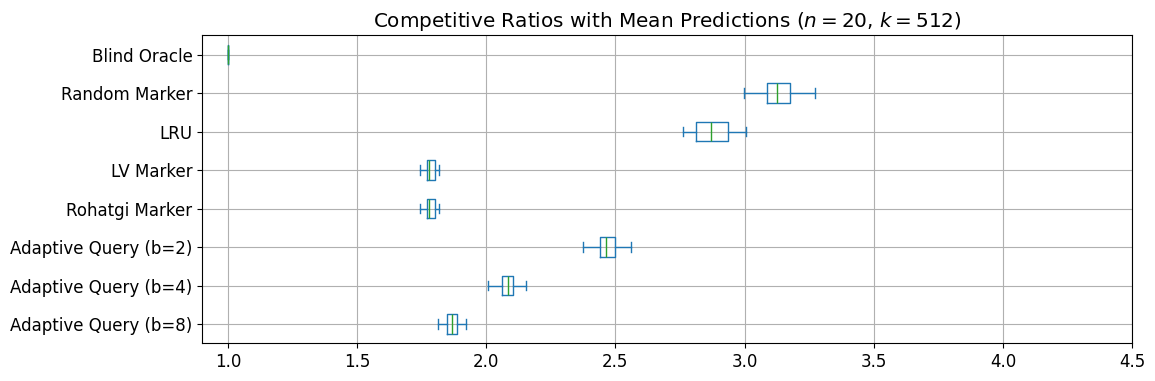

In [17]:
cols = [
    'adaptive_query_8',
    'adaptive_query_4',
    'adaptive_query_2',
    'rohatgi_marker',
    'lv_marker',
    'lru',
    'random_marker',
    'blind_oracle',
]
dfs_mp = df_mp.astype('float')
for month in dfs_mp['month'].unique():
    dfs_mp.loc[dfs_mp['month'] == month, cols] /= dfs_mp[dfs_mp['month'] == month]['fif'].values[0]
dfs_mp.drop(columns=['sigma', 'fif', 'month'], inplace=True)

ax = dfs_mp.plot.box(vert=False, title=fr'Competitive Ratios with Mean Predictions ($n=20$, $k=512$)', grid=True, xlim=(0.9, 4.5), figsize=(12, 4), y=cols)
ax.set_yticklabels([
    'Adaptive Query (b=8)',
    'Adaptive Query (b=4)',
    'Adaptive Query (b=2)',
    'Rohatgi Marker',
    'LV Marker',
    'LRU',
    'Random Marker',
    'Blind Oracle',
])

plt.show()

## Competitive Ratios of Adaptive Algorithm

In [18]:
def compute_adaptive(month, sigmas, bs, k=500, logk=7, n=25000, repetitions=20):
    pages, warmed_up_cache, rounds_per_page = get_data(folder, year, month, n, k)
    fif = generic_algorithm(warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk, FarthestInTheFuture(np.random.default_rng(), 0, True))
    
    data = []
    for _ in range(repetitions):
        for sigma in sigmas:
            for b in bs:
                data.append({
                    'sigma': sigma,
                    'month': month,
                    'b': b,
                    'cr': generic_marking_algorithm(
                        warmed_up_cache.copy(), list(pages), rounds_per_page, n, k, logk,
                        AdaptiveQuery(np.random.default_rng(), sigma, True, b)
                    ) / fif
                })
    return data

def compute_adaptive_for_all_months(filename="results-adaptive.csv", k=500, logk=7, n=25000, num_repetitions=20):
    if os.path.exists(filename):
        return pd.read_csv(filename)
    
    bs = 2**np.arange(0, 8)
    sigmas = [0, 2, 5, 10, 15, 20]
    
    data = []
    for month in ProgressBar(12):
        data += (compute_adaptive(month + 1, sigmas, bs, k, logk, n, num_repetitions))

    df_adaptive = pd.DataFrame(data)
    df_adaptive.to_csv(filename, index=False)
    return df_adaptive

In [19]:
df_adaptive = compute_adaptive_for_all_months()
bs = 2**np.arange(0, 8)
sigmas = [0, 2, 5, 10, 15, 20]

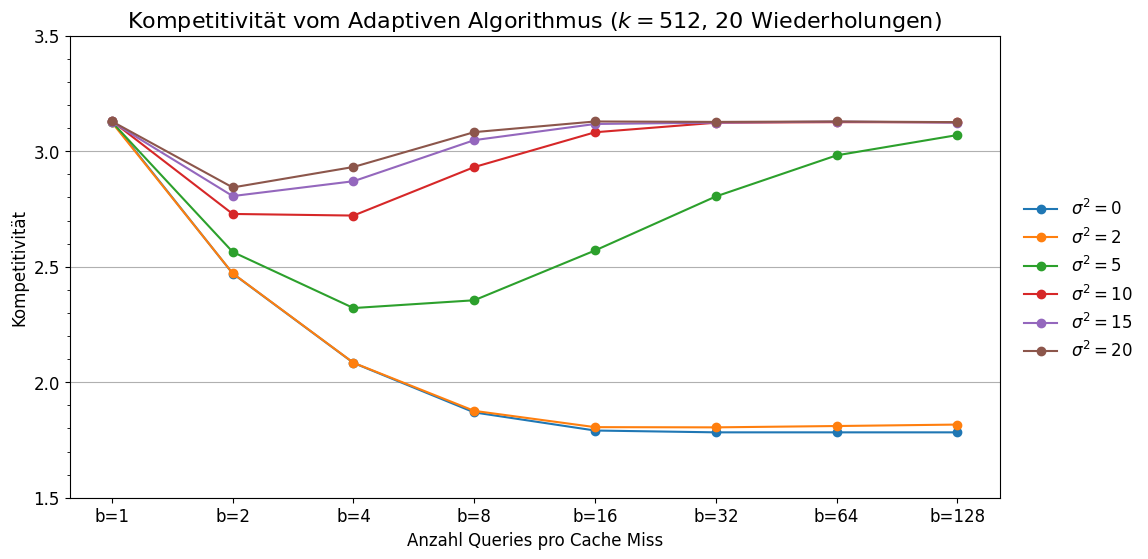

In [20]:
plt.figure(figsize=(12, 6))
ax = plt.subplot()

for sigma in sigmas:
    data_sigma = df_adaptive[df_adaptive['sigma'] == sigma].groupby('b')['cr'].mean()
    plt.plot(bs, data_sigma, label=fr'$\sigma^2={sigma}$', marker='o')
    # plt.scatter(bs, data[sigma], label=fr'$\sigma^2={sigma}$')

plt.xscale('log', base=2)
plt.grid(axis='y')
plt.ylim(1.5, 3.5)
plt.xticks(bs, [f'b={b}' for b in bs])
plt.yticks(np.arange(1.5, 3.6, 0.1))
plt.title(r'Kompetitivität vom Adaptiven Algorithmus ($k=512$, 20 Wiederholungen)', fontsize=16)
plt.xlabel('Anzahl Queries pro Cache Miss')
plt.ylabel('Kompetitivität')
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.1))
plt.legend(bbox_to_anchor=(1.01, 0.68), loc='upper left', frameon=False)
plt.show()

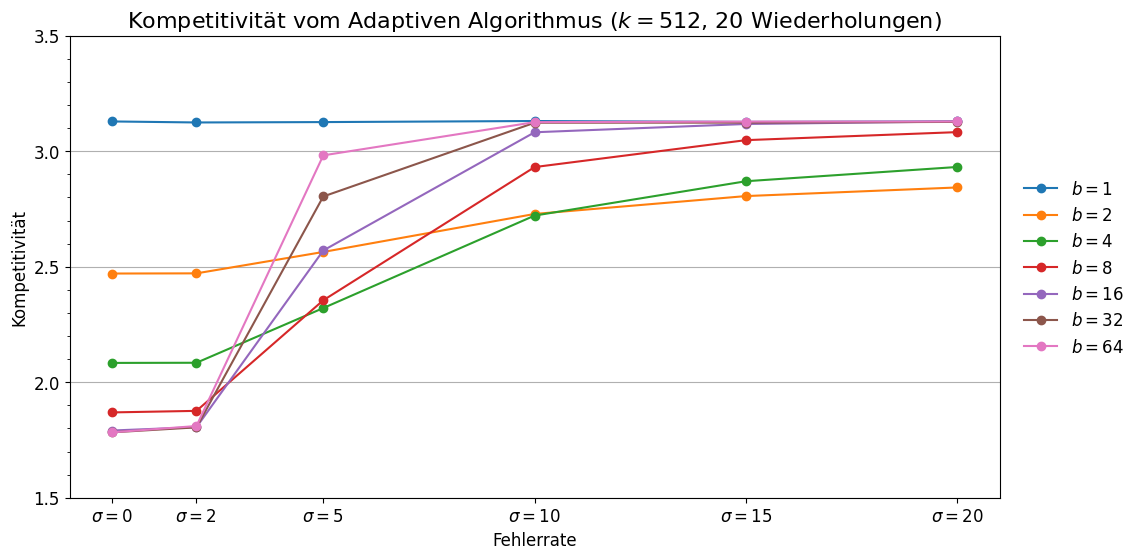

In [21]:
from matplotlib.legend_handler import HandlerLine2D, HandlerNpoints, HandlerTuple

plt.figure(figsize=(12, 6))

for b in bs[:-1]:
    data_sigma = df_adaptive[df_adaptive['b'] == b].groupby('sigma')['cr'].mean()
    plt.plot(sigmas, data_sigma, label=fr'$b={b}$', marker='o')
    # plt.scatter(bs, data[sigma], label=fr'$\sigma^2={sigma}$')

plt.grid(axis='y')
plt.ylim(1.5, 3.5)
plt.xticks(sigmas, [fr'$\sigma={sigma}$' for sigma in sigmas])
plt.yticks(np.arange(1.5, 3.6, 0.1))
plt.title(r'Kompetitivität vom Adaptiven Algorithmus ($k=512$, 20 Wiederholungen)', fontsize=16)
plt.xlabel('Fehlerrate')
plt.ylabel('Kompetitivität')
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.1))
plt.legend(bbox_to_anchor=(1.01, 0.72), loc='upper left', frameon=False)
# plt.legend()
plt.show()

## Development of competitive ratios

In [22]:
def generic_algorithm_2(cache: set, pages: list, rounds_per_page: dict, n: int, k: int, logk: int, eviction_strategy: EvictionStrategy, step_size: int):
    count = 0
    results = []
    last_idxs = {}
    eviction_strategy.reset(n, k, logk)
    
    for round, page in enumerate(pages):
        if page in cache:
            pass
        else:
            evicted_page = eviction_strategy.evict(cache, rounds_per_page, last_idxs, round)
            cache.remove(evicted_page)
            cache.add(page)
            count += 1
        
        if round % step_size == 0:
            results.append(count)
    
    return results

def generic_marking_algorithm_2(cache: set, pages: list, rounds_per_page: dict, n: int, k: int, logk: int, eviction_strategy: EvictionStrategy, step_size: int):
    count = 0
    results = []
    unmarked: set = cache.copy()
    last_idxs = {}
    phase_length = 0
    eviction_strategy.reset(n, k, logk)
    
    for round, page in enumerate(pages):
        if page in cache:
            if page in unmarked:
                unmarked.remove(page)
        else:
            # unmark all pages if all pages are marked
            if len(unmarked) == 0:
                # start of new phase
                # print(f"new phase at round {round}") # deterministic no matter which eviction strategy is used
                unmarked = cache.copy()
                phase_length = 0
            
            # evict an unmarked page
            evicted_page = eviction_strategy.evict(unmarked, rounds_per_page, last_idxs, round, phase_length)
            cache.remove(evicted_page)
            if evicted_page in unmarked:
                unmarked.remove(evicted_page)
            count += 1
            phase_length += 1
            
            # add current page to cache and mark it
            cache.add(page)
        
        if round % step_size == 0:
            results.append(count)

    return results

/tmp/ipykernel_4971/2003668682.py:12: RuntimeWarning: invalid value encountered in divide
  return np.array(adaptive_query_results) / np.array(fif_results)
/tmp/ipykernel_4971/2003668682.py:16: RuntimeWarning: invalid value encountered in divide
  return np.array(lv_marker_results) / np.array(fif_results)


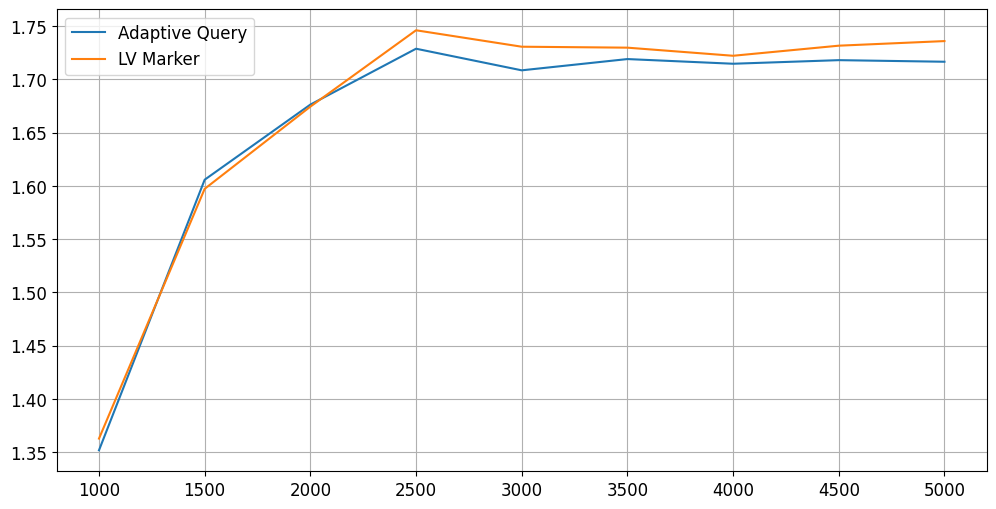

interactive(children=(IntSlider(value=100, continuous_update=False, description='k', max=500, min=20, step=5),…

In [23]:
rng = np.random.default_rng(87912124)
max_n = 5000
cache_size = 100
logk = 100
sigma = 16
steps = np.arange(500, max_n + 1, 500)
pages, warmed_up_cache, rounds_per_page = get_data(folder, year, 9, max_n, cache_size)
fif_results = generic_algorithm_2(warmed_up_cache.copy(), list(pages), rounds_per_page, max_n, cache_size, logk, FarthestInTheFuture(rng, 0, True), 500)

def aq_data():
    adaptive_query_results = generic_marking_algorithm_2(warmed_up_cache.copy(), list(pages), rounds_per_page, max_n, cache_size, logk, AdaptiveQuery(rng, sigma, True, 4), 500)
    return np.array(adaptive_query_results) / np.array(fif_results)

def lvm_data():
    lv_marker_results = generic_marking_algorithm_2(warmed_up_cache.copy(), list(pages), rounds_per_page, max_n, cache_size, logk, LVMarker(rng, sigma, True), 500)
    return np.array(lv_marker_results) / np.array(fif_results)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
aq_line, = ax.plot(steps, aq_data(), label="Adaptive Query")
lvm_line, = ax.plot(steps, lvm_data(), label="LV Marker")
plt.grid()
plt.legend()
# plt.show()

def update(k = 100, logk = 100, sigma = 8):
    print(f"gugus {k} {logk} {sigma}")
    aq_line.set_ydata(aq_data())
    lvm_line.set_ydata(lvm_data())
    # fig.canvas.draw()
    # return fig


_ = widgets.interact(
    update,
    k=widgets.IntSlider(min=20, max=500, step=5, value=100, continuous_update=False),
    logk=widgets.IntSlider(min=20, max=500, step=5, value=100, continuous_update=False),
    sigma=widgets.IntSlider(min=1, max=20, step=1, value=8, continuous_update=False)
)